# Оглавление
* [Описание проекта](#b0)
* [1. Загрузка и анализ данных](#b1)
* [2. Обучение модели](#b2)
* [3. Анализ обученной модели](#b3)

# Описание проекта<a class="anchor" id="b0"></a>

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: 

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.Предоставлен набор фотографий людей с указанием возраста.

### Описание данных

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/). Они находились в папке data/faces/ (удалены, так как слишком объемные). 

Предоставлена одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 

# 1. Загрузка и анализ данных<a class="anchor" id="b1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data = pd.read_csv("/datasets/faces/labels.csv")
print("Размер выборки:", data.shape)

Размер выборки: (7591, 2)


В выборке есть 7591 записей, это не так много, поэтому для увеличения тренировочной выборки вероятно понадобится аугментация. Например, повороты и отображения. Их должно хватить, при этом добавляйть следует по одной и следить за изменением метрики качества на валидационном наборе. Кроме того, можно использовать уже предобученненную на большом объёме данных нейросеть.

Посмотрим на график распределения возраста в выборке

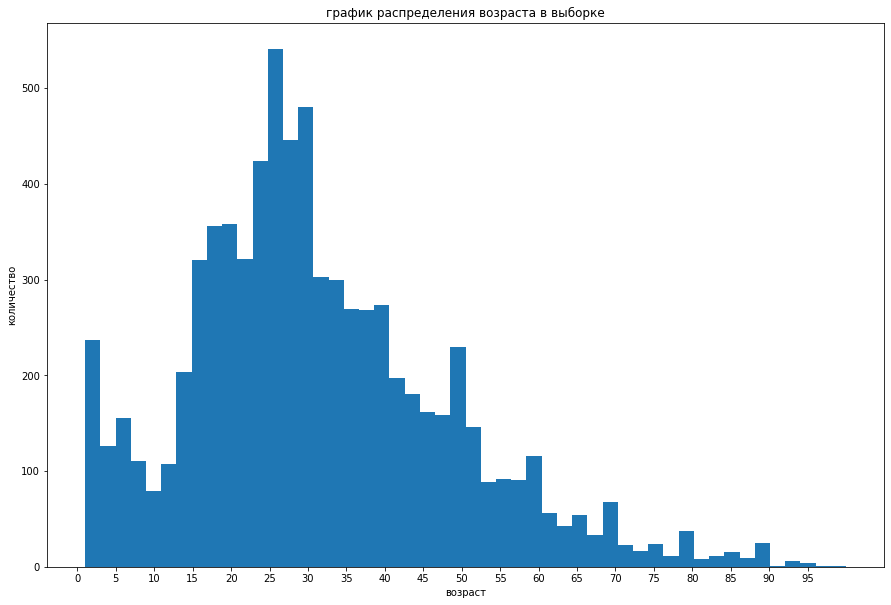

In [2]:
plt.figure(figsize=(15,10))
plt.title("график распределения возраста в выборке")
plt.xlabel('возраст')
plt.ylabel('количество')
plt.xticks(range(0,100, 5))
plt.hist(data['real_age'], bins = 50)
plt.show()

График распределения возраста в выборке распределен нормально, со сдвигом влево, выбросов нет. Наибольшие пики находятся на отметках 15 - 40

посмотрим на примеры изобржаений, которые у нас имеются

Found 7591 validated image filenames.


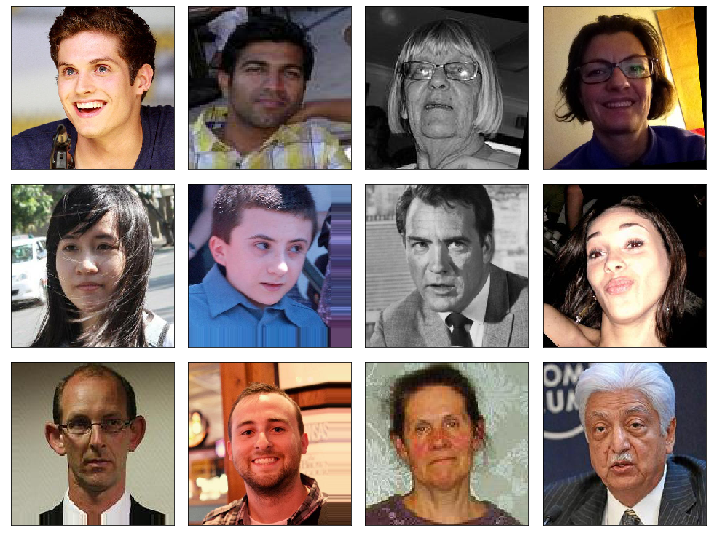

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe = data,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12)
features, target = next(datagen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии довольно разные: черно-белые и цветные, разного качества, в разной обстановке и сразными выражениями лиц

## Вывод

Датасет довольно хорошо подходит под нашу задачу. Основная часть людей в датасете -- это люди в возрасте 15-60 лет, то есть как раз те, кто чаще остальных ходит в магазины. Наша модель такие возрастные категории должна хорошо идентифицировать. Но не помешало бы ещё добавить больше фото людей в возрасте от 10 до 15 лет, тогда было бы идеально


Для решения задачи можно использовать архитектуру ResNet50, которая умеет хорошо справляться с задачами компьютерного зрения, а для улучшения метрики качества следует применить аугментацию

# 2. Обучение модели<a class="anchor" id="b2"></a>

Модель была обучена в GPU-тренажёре, ниже приведен код и результат вывода модели на экран.

### Код

```python

from tensorflow import keras
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow  = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='validation')

    return test_gen_flow  

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model


```

### Вывод приложения

```

2020-09-05 17:05:39.781311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-09-05 17:05:40.280827: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-09-05 17:05:56.620179: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-09-05 17:05:57.291935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-09-05 17:05:57.292060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-09-05 17:05:57.292097: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-05 17:05:57.593709: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-09-05 17:05:57.661421: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-09-05 17:05:58.972231: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-09-05 17:05:59.036016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-09-05 17:05:59.036114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-09-05 17:05:59.039699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-09-05 17:05:59.040090: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-09-05 17:05:59.269548: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-09-05 17:05:59.272995: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4388720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-09-05 17:05:59.273026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-09-05 17:05:59.721831: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4560040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-09-05 17:05:59.721874: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-09-05 17:05:59.723872: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-09-05 17:05:59.723940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-09-05 17:05:59.723953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-05 17:05:59.723977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-09-05 17:05:59.723992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-09-05 17:05:59.724005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-09-05 17:05:59.724017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-09-05 17:05:59.724026: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-09-05 17:05:59.727986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-09-05 17:05:59.737430: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-09-05 17:06:06.922240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-09-05 17:06:06.922319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-09-05 17:06:06.922330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-09-05 17:06:06.950305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2020-09-05 17:06:48.030302: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-05 17:06:52.180115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 116s - loss: 233.0432 - mae: 10.9600 - val_loss: 978.2001 - val_mae: 26.5376
Epoch 2/20
178/178 - 43s - loss: 73.6767 - mae: 6.4147 - val_loss: 943.6733 - val_mae: 25.9107
Epoch 3/20
178/178 - 43s - loss: 50.5554 - mae: 5.3511 - val_loss: 280.5835 - val_mae: 12.3155
Epoch 4/20
178/178 - 42s - loss: 35.3095 - mae: 4.5643 - val_loss: 105.3473 - val_mae: 7.7878
Epoch 5/20
178/178 - 42s - loss: 27.7404 - mae: 4.0311 - val_loss: 74.3076 - val_mae: 6.5015
Epoch 6/20
178/178 - 42s - loss: 22.3577 - mae: 3.6236 - val_loss: 66.8583 - val_mae: 6.0713
Epoch 7/20
178/178 - 43s - loss: 16.2826 - mae: 3.1137 - val_loss: 65.7499 - val_mae: 6.1910
Epoch 8/20
178/178 - 43s - loss: 13.3785 - mae: 2.8013 - val_loss: 67.1790 - val_mae: 6.1540
Epoch 9/20
178/178 - 43s - loss: 11.3681 - mae: 2.5734 - val_loss: 95.1673 - val_mae: 7.4313
Epoch 10/20
178/178 - 43s - loss: 10.7871 - mae: 2.5137 - val_loss: 65.0908 - val_mae: 6.0376
Epoch 11/20
178/178 - 42s - loss: 9.5922 - mae: 2.3521 - val_loss: 63.0654 - val_mae: 5.8983
Epoch 12/20
178/178 - 43s - loss: 8.8403 - mae: 2.2507 - val_loss: 62.5369 - val_mae: 5.9142
Epoch 13/20
178/178 - 43s - loss: 8.1573 - mae: 2.1339 - val_loss: 67.1979 - val_mae: 6.0545
Epoch 14/20
178/178 - 42s - loss: 7.8440 - mae: 2.0996 - val_loss: 61.3201 - val_mae: 5.9080
Epoch 15/20
178/178 - 43s - loss: 7.3764 - mae: 2.0524 - val_loss: 75.9977 - val_mae: 6.3774
Epoch 16/20
178/178 - 43s - loss: 7.5180 - mae: 2.0723 - val_loss: 62.2248 - val_mae: 5.8790
Epoch 17/20
178/178 - 43s - loss: 7.4402 - mae: 2.0570 - val_loss: 64.3073 - val_mae: 5.9549
Epoch 18/20
178/178 - 43s - loss: 7.0879 - mae: 1.9991 - val_loss: 70.8766 - val_mae: 6.4180
Epoch 19/20
178/178 - 42s - loss: 6.8552 - mae: 1.9802 - val_loss: 86.8663 - val_mae: 6.9207
Epoch 20/20
178/178 - 43s - loss: 6.3709 - mae: 1.9031 - val_loss: 59.7102 - val_mae: 5.7017
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 59.7102 - mae: 5.7017
Test MAE: 5.7017



```

# 3. Анализ обученной модели<a class="anchor" id="b3"></a>

Модель показала хороший результат по MAE, не переобучилась, несмотря на глубину. При этом обучилась достаточно быстро благодаря предобученному слою "backbone" из ResNet50. При этом можно было использовать меньшее количество эпох, и все равно пройти поставленный порог MAE <= 8, сэкономив время. Тут нужно смотреть, что для нас важнее - время и ресурсы или качество